# Natural Language Processing Project

## Preamble

### Modules

Import the needed modules for translation and confidence determination.

This environment variable customizes PyTorch’s CUDA memory allocator to reduce fragmentation and improve memory utilization

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True,max_split_size_mb:128

### **Purpose of each library imported below**
###Model setup and inference

Use snapshot_download and transformers to load the model & tokenizer

Use torch to generate translations and compute token-level probabilities, then produce sentence-level confidence

###Data structuring

Store results in pandas.DataFrame columns like "source", "translation", and "confidence"

###Visualization

Use seaborn + matplotlib or scipy.gaussian_kde to plot histograms and KDE curves over confidences

###Progress monitoring

Use tqdm to show progress as batches of text get translated over long loops

###Memory management

Use gc.collect() and torch.cuda.empty_cache() for releasing memory after model unload or batch processing

###Display outputs

Use IPython.display.display() to neatly render DataFrame views inside notebooks (e.g. showing top/bottom translations by confidence)

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import seaborn as sns
import gc

from transformers import pipeline
from google.colab import files
from tqdm import tqdm
from scipy.stats import gaussian_kde
from IPython.display import display
from typing import List, Tuple
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from huggingface_hub import snapshot_download

### Configuration

Define the model and tokenizer to be used for translation.

Load the model onto the GPU for speedy inference.

This will Download the entire model repository from Hugging Face

In [ ]:
model_name = "facebook/nllb-200-distilled-600M"

snapshot_download(
    repo_id=model_name,
    cache_dir=None,  # bypass cache
    local_dir="./nllb_model",
    local_dir_use_symlinks=False,
    resume_download=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a loc

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

'/content/nllb_model'

Define a pipeline for direct translation from:

- English to Swahili
- Swahili to Luo

In [ ]:
# Initialize translation pipelines
#eng_to_swa = pipeline("translation", model=model, tokenizer=tokenizer, src_lang="eng_Latn", tgt_lang="swh_Latn")
#swa_to_luo = pipeline("translation", model=model, tokenizer=tokenizer, src_lang="swh_Latn", tgt_lang="luo_Latn")

### Utility Functions

Translates directly from:

- English to Swahili
- Swahili to Luo

###English to Swahili
It takes a list of English texts, uses a Hugging Face translation pipeline (eng_to_swa) to convert them to Kiswahili in batches of size 8, tracks progress with a tqdm progress bar, extracts the translated string from each output’s 'translation_text' field, and returns a list of Kiswahili translations in the same order as the input.

### Swahili to Luo
It takes a list of kiswahili texts, uses a Hugging Face translation pipeline (swa_to_luo) to convert them to luo in batches of size 8, tracks progress with a tqdm progress bar, extracts the translated string from each output’s 'translation_text' field, and returns a list of luo translations in the same order as the input.

In [ ]:
"""def translate_to_swahili(texts):
    swahili_translations = []
    for item in tqdm(eng_to_swa(texts, batch_size=8), desc="Translating"):
        swahili_translations.append(item['translation_text'])
    return swahili_translations"""

'def translate_to_swahili(texts):\n    swahili_translations = []\n    for item in tqdm(eng_to_swa(texts, batch_size=8), desc="Translating"):\n        swahili_translations.append(item[\'translation_text\'])\n    return swahili_translations'

In [ ]:
"""def translate_to_luo(texts):
    luo_translations = []
    for item in tqdm(swa_to_luo(texts, batch_size=8), desc="Translating"):
        luo_translations.append(item['translation_text'])
    return luo_translations"""

'def translate_to_luo(texts):\n    luo_translations = []\n    for item in tqdm(swa_to_luo(texts, batch_size=8), desc="Translating"):\n        luo_translations.append(item[\'translation_text\'])\n    return luo_translations'

###Translates a sentence from one language to another determining the confidence for each translation.

The **translate_batch_with_confidence** function loads the NLLB‑200 translation model and tokenizer locally, moves the model to GPU in evaluation mode, and processes input texts in small sub‑batches.

 Each chunk is tokenized, sent to the GPU, and translated with generation scores enabled.

  It then extracts token-level logits to compute sentence confidence using the geometric mean of token probabilities.
  
   Generated translations and their confidence scores are aggregated, GPU cache is cleared after each sub-batch, and finally the model is unloaded and all memory freed before returning lists of translations and confidences.

In [ ]:
def translate_batch_with_confidence(
    texts: List[str],
    src_lang: str = "eng_Latn",
    tgt_lang: str = "swh_Latn",
    device: torch.device = None,
    sub_batch_size: int = 1
) -> Tuple[List[str], List[float]]:
    translations = []
    confidences = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSeq2SeqLM.from_pretrained("./nllb_model", local_files_only=True).to(device)
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(
      "./nllb_model",
      src_lang=src_lang,
      tgt_lang=tgt_lang, local_files_only=True)

    for start in range(0, len(texts), sub_batch_size):
        chunk = texts[start:start + sub_batch_size]

        inputs = tokenizer(chunk, return_tensors="pt", padding=True,
                           truncation=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        forced_bos = tokenizer.convert_tokens_to_ids(tgt_lang)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                forced_bos_token_id=forced_bos,
                output_scores=True,
                return_dict_in_generate=True
            )

        seqs, scores = outputs.sequences, outputs.scores

        for i in range(seqs.size(0)):
            token_probs = [
                F.softmax(scores[s][i], dim=-1)[seqs[i, s + 1]].item()
                for s in range(len(scores))
            ]
            conf = math.exp(sum(math.log(p + 1e-12) for p in token_probs) / len(token_probs)) if token_probs else 0.0
            translations.append(tokenizer.decode(seqs[i], skip_special_tokens=True))
            confidences.append(conf)

        # Free reserved cache after this chunk
        torch.cuda.empty_cache()

    model.cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    return translations, confidences

Plots a histogram with a line overlay for the confidences of translation.

In [ ]:
def plot_confidence_distribution(confidences, bins=30, bw_adjust=1.0,
                                 hist_color='skyblue', kde_color='darkblue',
                                 kde_linewidth=2):
    """
    Plot histogram of confidence scores with a KDE line overlay.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))

    # Histogram part
    sns.histplot(
        confidences,
        bins=bins,
        stat='density',
        color=hist_color,
        alpha=0.6,
        edgecolor='black'
    )

    # KDE part overlaid
    sns.kdeplot(
        confidences,
        bw_adjust=bw_adjust,
        color=kde_color,
        linewidth=kde_linewidth
    )

    plt.xlabel("Confidence score")
    plt.ylabel("Density")
    plt.title("Histogram of Translation Confidence with KDE")
    plt.tight_layout()
    plt.show()

Displays the most confident and least confident translations in the dataframe.

In [ ]:
def show_extreme_confidences(
    df: pd.DataFrame,
    source_col: str,
    translation_col: str,
    confidence_col: str,
    top_n: int = 5
):
    """
    Display the top_n most confident and least confident translations including original source.

    :param df: pandas DataFrame containing translations
    :param source_col: column name of the original/source text
    :param translation_col: column name for translated text
    :param confidence_col: column name for confidence scores
    :param top_n: number of extremes to show (default 5)
    :returns: styled DataFrames displayed via Jupyter
    """
    # Validate that columns exist
    for col in (source_col, translation_col, confidence_col):
        if col not in df.columns:
            raise KeyError(f"Missing column: {col}")

    df_top = (df.nlargest(top_n, confidence_col)
                [[source_col, translation_col, confidence_col]]
                .reset_index(drop=True))
    df_bot = (df.nsmallest(top_n, confidence_col)
                [[source_col, translation_col, confidence_col]]
                .reset_index(drop=True))

    def highlight_rows(x: pd.Series):
        return ['font-weight: bold;' for _ in x]

    print(f"Top {top_n} Most Confident Translations:")
    display(
        df_top.style.set_caption(f"Top {top_n} by '{confidence_col}'")
                    .apply(highlight_rows, axis=1)
    )

    print(f"\nTop {top_n} Least Confident Translations:")
    display(
        df_bot.style.set_caption(f"Bottom {top_n} by '{confidence_col}'")
                    .apply(highlight_rows, axis=1)
    )

## Data Cleaning


### Data Importation

In [ ]:
# Load the dataset
df = pd.read_csv("/content/sample_data/kenya_education_psas_compile.csv", encoding='latin-1')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PSA_ID               1103 non-null   int64  
 1   Sub_Category         1103 non-null   object 
 2   Title                1103 non-null   object 
 3   PSAs Description     1103 non-null   object 
 4   Source               1102 non-null   object 
 5   Date                 1102 non-null   object 
 6   Format               1102 non-null   object 
 7   Topic                1102 non-null   object 
 8   Original_Language    1102 non-null   object 
 9   URL                  1100 non-null   object 
 10  Translation_Swahili  625 non-null    object 
 11  Translation_Luo      71 non-null     object 
 12  Unnamed: 12          201 non-null    object 
 13  Unnamed: 13          0 non-null      float64
 14  Unnamed: 14          0 non-null      float64
 15  Unnamed: 15          0 non-null      f

In [ ]:
 df.head()

,PSA_ID,Sub_Category,Title,PSAs Description,Source,Date,Format,Topic,Original_Language,URL,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,268,Access to Education,Senior school selection process,We have worked on guidelines to transition our...,Press conference,24/04/2025,Text,Education,English,https://www.kenyans.co.ke/news/111409-grade-9-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,269,Access to Education,Mid-year KCSE examinations,"Starting this year, and following extensive st...",Official announcement,09/01/2025,Text,Education,English,https://www.the-star.co.ke/news/realtime/2025-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,270,Access to Education,University admission policy,The Government has not re-introduced cut-off p...,Policy clarification,28/02/2025,Text,Education,English,https://www.capitalfm.co.ke/news/2024/12/minis...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,271,Access to Education,Teacher recruitment drive,The Teachers Service Commission (TSC) will nex...,Recruitment announcement,30/09/2024,Text,Education,English,https://nation.africa/kenya/news/education/tsc...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,272,Access to Education,Teacher career progression,"TSC has also agreed to convert all the 26,000 ...",Official announcement,30/11/2024,Text,Education,English,https://cbc.co.ke/tsc-postpones-recruitment-of...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [ ]:
# Clean dataset
df_cleaned = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df_cleaned = df_cleaned.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce', dayfirst=True)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   PSA_ID               1103 non-null   int64         
 1   Sub_Category         1103 non-null   object        
 2   Title                1103 non-null   object        
 3   PSAs Description     1103 non-null   object        
 4   Source               1102 non-null   object        
 5   Date                 823 non-null    datetime64[ns]
 6   Format               1102 non-null   object        
 7   Topic                1102 non-null   object        
 8   Original_Language    1102 non-null   object        
 9   URL                  1100 non-null   object        
 10  Translation_Swahili  625 non-null    object        
 11  Translation_Luo      71 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 103.5+ KB


In [ ]:
df_cleaned.head(5)

,PSA_ID,Sub_Category,Title,PSAs Description,Source,Date,Format,Topic,Original_Language,URL,Translation_Swahili,Translation_Luo
0,268,Access to Education,Senior school selection process,We have worked on guidelines to transition our...,Press conference,2025-04-24,Text,Education,English,https://www.kenyans.co.ke/news/111409-grade-9-...,NaN,NaN
1,269,Access to Education,Mid-year KCSE examinations,"Starting this year, and following extensive st...",Official announcement,2025-01-09,Text,Education,English,https://www.the-star.co.ke/news/realtime/2025-...,NaN,NaN
2,270,Access to Education,University admission policy,The Government has not re-introduced cut-off p...,Policy clarification,2025-02-28,Text,Education,English,https://www.capitalfm.co.ke/news/2024/12/minis...,NaN,NaN
3,271,Access to Education,Teacher recruitment drive,The Teachers Service Commission (TSC) will nex...,Recruitment announcement,2024-09-30,Text,Education,English,https://nation.africa/kenya/news/education/tsc...,NaN,NaN
4,272,Access to Education,Teacher career progression,"TSC has also agreed to convert all the 26,000 ...",Official announcement,2024-11-30,Text,Education,English,https://cbc.co.ke/tsc-postpones-recruitment-of...,NaN,NaN


### Data Saving

In [ ]:
# Save cleaned dataset
df_cleaned.to_csv('cleaned_Education_PSAs.csv', index=False)

### Data Validation

In [ ]:
# Data types
data_types = df_cleaned.dtypes

# Unique values in categorical fields
unique_topics = df_cleaned['Topic'].unique()
unique_languages = df_cleaned['Original_Language'].unique()
unique_formats = df_cleaned['Format'].unique()

# Check URL format and average length of Title/Description
url_validity = df_cleaned['URL'].str.startswith(('http://', 'https://')).value_counts()
title_len_stats = df_cleaned['Title'].str.len().describe()
desc_len_stats = df_cleaned['PSAs Description'].str.len().describe()

In [ ]:
data_types

,0
PSA_ID,int64
Sub_Category,object
Title,object
PSAs Description,object
Source,object
Date,datetime64[ns]
Format,object
Topic,object
Original_Language,object
URL,object


In [ ]:
unique_topics

array(['Education', 'Text', 'Audio', 'Digital', 'Image', 'Video',
       'Governance', 'Game', '20/03/2024', 'Voter Education', nan],
      dtype=object)

In [ ]:
desc_len_stats

,PSAs Description
count,1103.000000
mean,103.636446
std,54.632639
min,17.000000
25%,57.000000
50%,100.000000
75%,138.500000
max,378.000000


In [ ]:
title_len_stats

,Title
count,1103.000000
mean,36.137806
std,15.020888
min,12.000000
25%,25.000000
50%,33.000000
75%,46.000000
max,109.000000


In [ ]:
url_validity

,count
URL,
True,1095
False,5


In [ ]:
unique_formats

array(['Text', 'Image', 'Video', 'Poster', 'Radio', 'Voter Education',
       'Governance', 'Human Rights', 'Peace & Security', 'Devolution',
       'Finance', 'Youth Empowerment', 'Gender Equality', '29/12/2023',
       'Youth Agenda', '22/03/2024', 'Education', nan], dtype=object)

In [ ]:
unique_languages

array(['English', 'Text', 'Youth Empowerment', nan], dtype=object)

In [ ]:
unique_topics

array(['Education', 'Text', 'Audio', 'Digital', 'Image', 'Video',
       'Governance', 'Game', '20/03/2024', 'Voter Education', nan],
      dtype=object)

### Data Normalization

In [ ]:
# Normalize relevant fields
df_cleaned['Topic'] = df_cleaned['Topic'].astype(str).str.strip()
df_cleaned['Original_Language'] = df_cleaned['Original_Language'].astype(str).str.strip().str.capitalize()
df_cleaned['Format'] = df_cleaned['Format'].astype(str).str.lower().str.strip()
df_cleaned['PSAs Description'] = df_cleaned['PSAs Description'].astype(str).str.strip()
df_cleaned['URL'] = df_cleaned['URL'].astype(str).str.strip()

# Rule 1: Invalid topics (e.g., date accidentally recorded as topic)
invalid_topic_rows = df_cleaned[df_cleaned['Topic'].str.match(r'\d{1,2}/\d{1,2}/\d{4}')]

# Rule 2: Invalid languages
valid_languages = ['English', 'Swahili']
invalid_language_rows = df_cleaned[~df_cleaned['Original_Language'].isin(valid_languages)]

# Rule 3: Invalid formats
valid_formats = ['text', 'image/poster', 'video', 'audio']
invalid_format_rows = df_cleaned[~df_cleaned['Format'].isin(valid_formats)]

# Rule 4: Short descriptions (<20 characters)
short_description_rows = df_cleaned[df_cleaned['PSAs Description'].str.len() < 20]

# Rule 5: Missing publication date
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')
missing_date_rows = df_cleaned[df_cleaned['Date'].isnull()]

# Rule 6: Invalid URLs
invalid_url_rows = df_cleaned[~df_cleaned['URL'].str.startswith(('http://', 'https://'))]

In [ ]:
# Output the counts for each rule violation
validation_summary = {
    "Invalid Topic Rows": len(invalid_topic_rows),
    "Invalid Language Rows": len(invalid_language_rows),
    "Invalid Format Rows": len(invalid_format_rows),
    "Short Descriptions (<20 chars)": len(short_description_rows),
    "Missing Publication Dates": len(missing_date_rows),
    "Invalid URLs": len(invalid_url_rows),
}

In [ ]:
# Print summary
print("Validation Summary:")
for k, v in validation_summary.items():
    print(f"{k}: {v}")

Validation Summary:
Invalid Topic Rows: 1
Invalid Language Rows: 4
Invalid Format Rows: 471
Short Descriptions (<20 chars): 1
Missing Publication Dates: 280
Invalid URLs: 8


In [ ]:
# Optional: Save flagged rows to CSVs for review
invalid_topic_rows.to_csv("flagged_invalid_topics.csv", index=False)
invalid_language_rows.to_csv("flagged_invalid_languages.csv", index=False)
invalid_format_rows.to_csv("flagged_invalid_formats.csv", index=False)
short_description_rows.to_csv("flagged_short_descriptions.csv", index=False)
missing_date_rows.to_csv("flagged_missing_dates.csv", index=False)
invalid_url_rows.to_csv("flagged_invalid_urls.csv", index=False)

## Translation

In [ ]:
df_translated = pd.DataFrame()
df_translated['English'] = df_cleaned['PSAs Description']

### English to Swahili

In [ ]:
# Prepare inputs
english_texts = list(df_translated['English'])

In [ ]:
swahili_translations, swahili_confidences = translate_batch_with_confidence(
    english_texts,
    src_lang="eng_Latn",
    tgt_lang="swh_Latn"
)

In [ ]:
# Add to DataFrame
df_translated['Swahili Translations'] = swahili_translations
df_translated['Swahili Confidences'] = swahili_confidences

### Luo to Swahili

In [ ]:
luo_translations, luo_confidences = translate_batch_with_confidence(
    swahili_translations,
    src_lang="swh_Latn",
    tgt_lang="luo_Latn"
)

In [ ]:
df_translated['Luo Translations'] = luo_translations
df_translated['Luo Confidences'] = luo_confidences

### Translation Validation

In [ ]:
# Final DataFrame
df_translated.head(5)

,English,Swahili Translations,Swahili Confidences,Luo Translations,Luo Confidences
0,We have worked on guidelines to transition our...,Tumefanya kazi juu ya miongozo ya kuhamisha wa...,0.664207,Wasebedo ka watiyo gi chike ma tayowa mondo wa...,0.462591
1,"Starting this year, and following extensive st...","Kuanzia mwaka huu, na baada ya mashauriano ya ...",0.636827,"Chakre higani, kendo bang' wuoyo matut gi riwr...",0.566835
2,The Government has not re-introduced cut-off p...,Serikali haijaanzisha tena vituo vya kukataliw...,0.556450,Sirkal ok ochak chungo kuonde ma ji ok nyal do...,0.443875
3,The Teachers Service Commission (TSC) will nex...,Tume ya Huduma ya Walimu (TSC) itachapisha wik...,0.662241,TSC biro goyo twak e juma mabiro mar tich many...,0.289411
4,"TSC has also agreed to convert all the 26,000 ...","TSC pia imekubali kugeuza walimu wote 26,000 w...",0.565355,"TSC bende oseyie loko jopuonj 26,000 duto ma n...",0.467697


### Translation File Saving

In [ ]:
df_translated.to_csv("PSAs Translation Full.csv", index=False)

In [ ]:
files.download("PSAs Translation Full.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Translation Confidence Histogram Plot

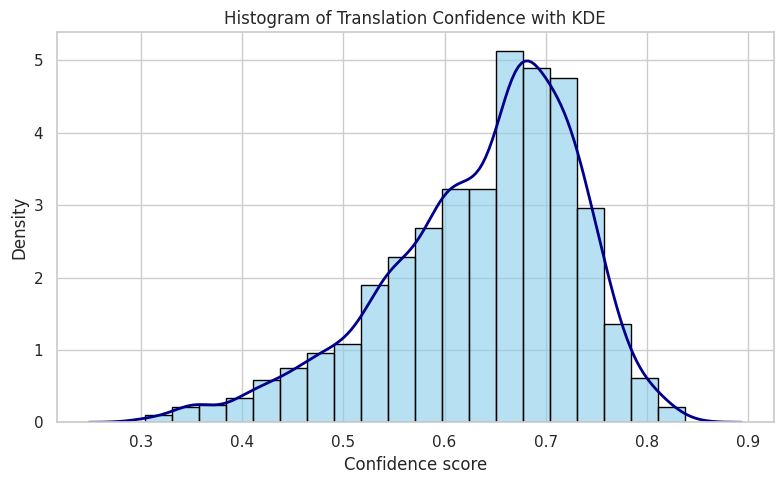

In [ ]:
plot_confidence_distribution(swahili_confidences, bins=20, bw_adjust=0.8)

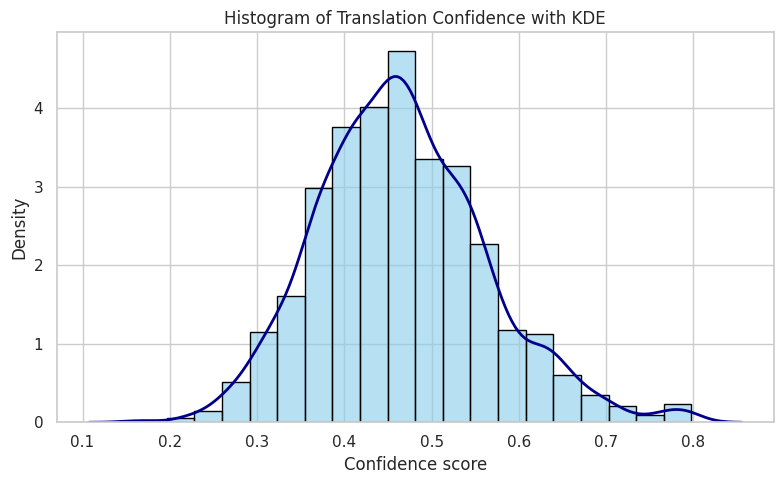

In [ ]:
plot_confidence_distribution(luo_confidences, bins=20, bw_adjust=0.8)

### Confidence Contrasts

In [ ]:
show_extreme_confidences(
    df_translated,
    source_col="English",
    translation_col="Swahili Translations",
    confidence_col="Swahili Confidences",
    top_n=3
)

Top 3 Most Confident Translations:


,English,Swahili Translations,Swahili Confidences
0,On July 27 2025 Deputy President Kithure Kindiki announced that TVET enrollment doubled from 297000 in 2022 to over 700000 due to government investment.,"Mnamo Julai 27, 2025, Makamu wa Rais Kithure Kindiki alitangaza kuwa usajili wa TVET uliongezeka mara mbili kutoka 297000 mnamo 2022 hadi zaidi ya 700000 kwa sababu ya uwekezaji wa serikali.",0.837770
1,Ministry of Education organizes training for school principals in leadership and management.,Wizara ya Elimu huandaa mafunzo kwa wakuu wa shule katika uongozi na usimamizi.,0.820128
2,IEBC collaborates with universities on voter education research.,IEBC inashirikiana na vyuo vikuu katika utafiti wa elimu ya wapiga kura.,0.819360



Top 3 Least Confident Translations:


,English,Swahili Translations,Swahili Confidences
0,Workshops for informal legal advocates,Warsha za Mafunzo kwa Wafanyakazi wa Sheria,0.304230
1,Painted stories of civic participation by women,Hadithi za wanawake wa kushiriki katika jamii,0.313574
2,Participants solve civic puzzles,Washiriki wa programu huamua maswali ya kiraia,0.326679


In [ ]:
show_extreme_confidences(
    df_translated,
    source_col="Swahili Translations",
    translation_col="Luo Translations",
    confidence_col="Luo Confidences",
    top_n=3
)

Top 3 Most Confident Translations:


,Swahili Translations,Luo Translations,Luo Confidences
0,Wazoeze walimu!,Tieg jopuonj!,0.797792
1,Wasaidie wanafunzi!,Kony jopuonjre!,0.796322
2,Wasaidie wanafunzi!,Kony jopuonjre!,0.796322



Top 3 Least Confident Translations:


,Swahili Translations,Luo Translations,Luo Confidences
0,Fund shule! kuhakikisha wakati capitation kwa utulivu.,Ne giwacho ni ne gin gi paro mowinjore kuom wach somo.,0.164799
1,Kila mtu anaweza kujifunza! Tumia maandishi ya vipofu na mifumo ya kuteleza kwa ajili ya wanafunzi wenye ulemavu.,Ti gi ranyisi mar welo kod gik ma inyalo somo e yo ma ok rumo.,0.213931
2,Timu zinashindana juu ya ujuzi wa uwajibikaji wa umma,Tunge duto piem e wi lony e timo gik ma ok ochuno,0.227585
